In [1]:
from google.colab import files
import os
import shutil
import zipfile
import glob
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from itertools import product
from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Function to upload images only if the folder is empty
def upload_images_to_folder(folder_name):
    """Check if folder contains images; if not, prompt user to upload."""
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)  # Create the folder if it doesn't exist
        print(f"📂 Created folder: {folder_name}")

    # Check for existing images (common image formats)
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')
    existing_images = [f for f in os.listdir(folder_name) if f.lower().endswith(image_extensions)]

    if existing_images:
        print(f"✅ Folder '{folder_name}' already contains images. Skipping upload.")
    else:
        print(f"📂 No images found in '{folder_name}'. Please upload images.")
        uploaded = files.upload()
        for filename in uploaded.keys():
            shutil.move(filename, os.path.join(folder_name, filename))
        print(f"✅ Images uploaded to '{folder_name}' successfully!")

# Function to extract and clean the dataset
def extract_and_clean_dataset(zip_file, extract_to):
    """Extract dataset from zip file and clean unnecessary files."""
    if not os.path.exists(zip_file):
        print(f"⚠️ Please upload the zip file: {zip_file}")
        uploaded = files.upload()
        if zip_file not in uploaded:
            raise FileNotFoundError(f"Expected file '{zip_file}' not uploaded.")

    # Check if dataset is already extracted
    if os.path.exists(extract_to) and len(os.listdir(extract_to)) > 0:
        print(f"✅ Dataset already extracted in '{extract_to}'.")
        return  # Skip extraction if dataset already exists

    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)

    # Unzip the file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"📂 Unzipping complete. Files extracted to: {extract_to}")

    # Remove __MACOSX folder if it exists
    macosx_path = os.path.join(extract_to, "__MACOSX")
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print("🗑️ Removed '__MACOSX' folder.")

    # Handle cases where the dataset is inside a nested folder
    inner_folders = [f for f in os.listdir(extract_to) if os.path.isdir(os.path.join(extract_to, f))]
    if len(inner_folders) == 1:
        inner_folder = os.path.join(extract_to, inner_folders[0])

        # Move files out of the inner folder
        for item in os.listdir(inner_folder):
            shutil.move(os.path.join(inner_folder, item), extract_to)

        # Remove the now-empty folder
        shutil.rmtree(inner_folder)
        print("📂 Removed nested dataset folder.")

    # Remove .DS_Store file if it exists
    ds_store_path = os.path.join(extract_to, ".DS_Store")
    if os.path.exists(ds_store_path):
        os.remove(ds_store_path)
        print("🗑️ Removed '.DS_Store' file.")

    print("✅ Dataset folder structure cleaned.")

# Define dataset zip file and extraction path
zip_file = "A2_Hand_Gesture_Dataset_revised.zip"  # Change to your ZIP file name
extract_to = "dataset"

# Step 1: Extract and clean the dataset
extract_and_clean_dataset(zip_file, extract_to)

# Step 2: Upload images only if needed
upload_images_to_folder("sample")
upload_images_to_folder("textures")


⚠️ Please upload the zip file: A2_Hand_Gesture_Dataset_revised.zip


Saving A2_Hand_Gesture_Dataset_revised.zip to A2_Hand_Gesture_Dataset_revised.zip
📂 Unzipping complete. Files extracted to: dataset
🗑️ Removed '__MACOSX' folder.
📂 Removed nested dataset folder.
🗑️ Removed '.DS_Store' file.
✅ Dataset folder structure cleaned.
📂 Created folder: sample
📂 No images found in 'sample'. Please upload images.


Saving 111_A_1.jpg to 111_A_1.jpg
Saving 111_A_2.jpg to 111_A_2.jpg
Saving 111_A_3.jpg to 111_A_3.jpg
Saving 111_B_1.jpg to 111_B_1.jpg
Saving 111_B_2.jpg to 111_B_2.jpg
Saving 111_B_3.jpg to 111_B_3.jpg
Saving 111_C_1.jpg to 111_C_1.jpg
Saving 111_C_2.jpg to 111_C_2.jpg
Saving 111_C_3.jpg to 111_C_3.jpg
Saving 111_D_1.jpg to 111_D_1.jpg
Saving 111_D_2.jpg to 111_D_2.jpg
Saving 111_D_3.jpg to 111_D_3.jpg
Saving 111_E_1.jpg to 111_E_1.jpg
Saving 111_E_2.jpg to 111_E_2.jpg
Saving 111_E_3.jpg to 111_E_3.jpg
Saving 111_F_1.jpg to 111_F_1.jpg
Saving 111_F_2.jpg to 111_F_2.jpg
Saving 111_F_3.jpg to 111_F_3.jpg
Saving 111_G_1.jpg to 111_G_1.jpg
Saving 111_G_2.jpg to 111_G_2.jpg
Saving 111_G_3.jpg to 111_G_3.jpg
Saving 111_H_1.jpg to 111_H_1.jpg
Saving 111_H_2.jpg to 111_H_2.jpg
Saving 111_H_3.jpg to 111_H_3.jpg
Saving 111_I_1.jpg to 111_I_1.jpg
Saving 111_I_2.jpg to 111_I_2.jpg
Saving 111_I_3.jpg to 111_I_3.jpg
✅ Images uploaded to 'sample' successfully!
📂 Created folder: textures
📂 No images

Saving classroom.jpg to classroom.jpg
Saving classroom2.jpg to classroom2.jpg
Saving desk.jpg to desk.jpg
Saving desk2.jpg to desk2.jpg
Saving outdoor.jpg to outdoor.jpg
Saving wall.jpg to wall.jpg
Saving wall2.jpg to wall2.jpg
Saving wall3.jpg to wall3.jpg
Saving wall3.png to wall3.png
Saving wall4.jpg to wall4.jpg
✅ Images uploaded to 'textures' successfully!


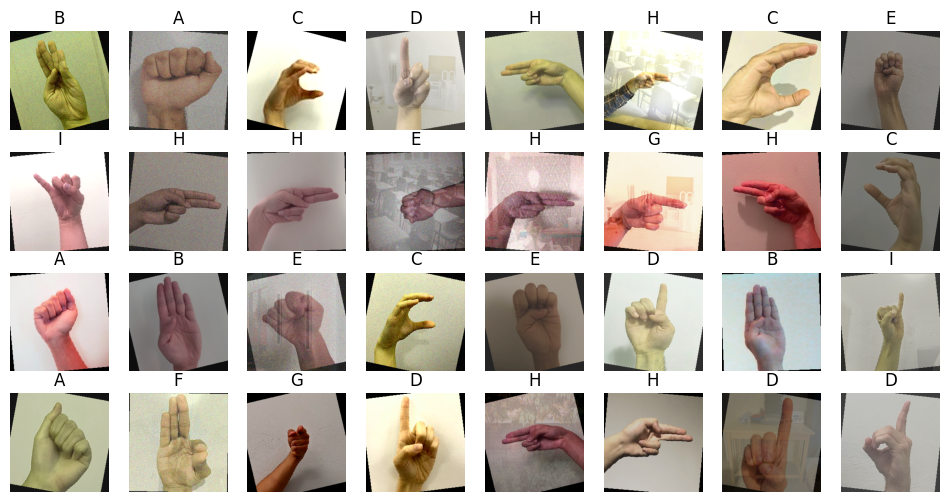

In [3]:
import torch
import random
import numpy as np
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from PIL import Image, ImageEnhance
import glob
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(999)
random.seed(999)
np.random.seed(999)

# Load texture backgrounds
texture_paths = glob.glob("textures/*.jpg")  # Folder where texture images are stored
textures = [Image.open(path).convert("RGB") for path in texture_paths]

def apply_texture_background(img):
    """Replaces the image's background with a random texture."""
    texture = random.choice(textures)
    texture = texture.resize(img.size)
    img = Image.blend(img, texture, alpha=0.2)  # Blend the image with the texture
    return img

def random_lighting(img):
    """Applies random brightness and contrast changes."""
    brightness_factor = random.uniform(0.7, 1.3)  # Random brightness change
    contrast_factor = random.uniform(0.7, 1.3)  # Random contrast change
    img = ImageEnhance.Brightness(img).enhance(brightness_factor)
    img = ImageEnhance.Contrast(img).enhance(contrast_factor)
    return img

class AddGaussianNoise(object):
    """Adds Gaussian noise to an image tensor."""
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

def get_augmentation_transform():
    """Creates a random augmentation pipeline including texture & lighting effects."""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),  # Mirror effect
        transforms.RandomRotation(15),  # Rotate within -15° to +15°
        transforms.RandomApply([transforms.Lambda(lambda img: apply_texture_background(img))], p=0.5),  # Background texture
        transforms.RandomApply([transforms.Lambda(lambda img: random_lighting(img))], p=0.5),  # Random brightness/contrast
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.ToTensor(),
        transforms.RandomApply([AddGaussianNoise(mean=0.0, std=0.05)], p=0.3),  # Add slight Gaussian noise
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

def data_augmentation_loader(data_dir, batch_size, valid_split=0.3):
    """
    Loads dataset while ensuring:
    ✅ 30% of people are selected for validation.
    ✅ Training data gets augmentation.
    ✅ Validation data remains unaltered.
    """

    # ✅ Define separate transforms BEFORE loading ImageFolder
    transform = get_augmentation_transform()

    # ✅ Load dataset (without transforms initially)
    dataset = datasets.ImageFolder(data_dir)  # We apply transform later
    classes = dataset.classes  # Class names

    # ✅ Group images by person ID (assuming filename format: personID_letter_seq.jpg)
    person_to_indices = defaultdict(list)
    for idx, (img_path, _) in enumerate(dataset.imgs):
        filename = os.path.basename(img_path)
        person_id = filename.split("_")[0]  # Extract person ID
        person_to_indices[person_id].append(idx)

    # ✅ Split people into training and validation
    all_people = list(person_to_indices.keys())
    random.shuffle(all_people)  # Shuffle before splitting
    valid_people_count = int(len(all_people) * valid_split)

    valid_people = set(all_people[:valid_people_count])
    train_people = set(all_people[valid_people_count:])

    # ✅ Get indices for train and validation sets
    train_indices = [idx for person in train_people for idx in person_to_indices[person]]
    val_indices = [idx for person in valid_people for idx in person_to_indices[person]]

    # ✅ Create separate datasets
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    # ✅ Apply transforms separately
    train_dataset.dataset.transform = transform
    val_dataset.dataset.transform = transform

    # ✅ Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, classes

def show_augmented_images(data_loader, classes):
    """Displays a batch of augmented images from the training data loader."""
    images, labels = next(iter(data_loader))

    # Reverse normalization: x' = x * std + mean (since std=0.5, mean=0.5)
    images = images * 0.5 + 0.5  # Convert values back to the [0, 1] range

    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        img = np.clip(img, 0, 1)  # Ensure values remain within the valid range [0,1] for imshow
        ax.imshow(img)
        ax.set_title(classes[label])
        ax.axis("off")  # Hide axis labels

    plt.show()

# ✅ Load dataset with augmentation
train_loader, val_loader, classes = data_augmentation_loader("dataset", batch_size=32)

# ✅ Show a batch of augmented images
show_augmented_images(train_loader, classes)


In [4]:
alexnet = models.alexnet(weights="DEFAULT")
alexnet.eval()

# Define save directory
save_dir = "saved_features"
os.makedirs(save_dir, exist_ok=True)

# Function to extract and save features
def extract_and_save_features(data_loader, save_path):
    features_list = []
    labels_list = []

    with torch.no_grad():  # No gradients needed for feature extraction
        for img, labels in data_loader:
            features = alexnet.features(img)  # Extract features
            features_list.append(features.cpu())  # Move to CPU to save
            labels_list.append(labels.cpu())

    # Convert to a single tensor
    features_tensor = torch.cat(features_list, dim=0)  # Stack all batches
    labels_tensor = torch.cat(labels_list, dim=0)

    # Save extracted features
    torch.save({"features": features_tensor, "labels": labels_tensor}, save_path)
    print(f"Saved features to {save_path}")

# Extract and save features for training, validation, and test sets
extract_and_save_features(train_loader, os.path.join(save_dir, "train_features.pth"))
extract_and_save_features(val_loader, os.path.join(save_dir, "val_features.pth"))

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 170MB/s]


Saved features to saved_features/train_features.pth
Saved features to saved_features/val_features.pth


In [5]:
class TransferGestureCNN(nn.Module):
    def __init__(self, conv1_channels=128, conv2_channels=256, fc1_units=256, fc2_units=128, kernel_size=3, stride=1, padding=1):
        super(TransferGestureCNN, self).__init__()

        padding = (kernel_size - 1) // 2  # Ensures feature map size is preserved

        # Convolutional layers (input from AlexNet features)
        self.conv1 = nn.Conv2d(256, conv1_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(conv1_channels)

        self.conv2 = nn.Conv2d(conv1_channels, conv2_channels, kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(conv2_channels)

        # Adaptive Pooling ensures fixed output size (3x3)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))

        # Fully connected layers
        self.fc1 = nn.Linear(conv2_channels * 3 * 3, fc1_units)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(fc2_units, 9)  # 9 gesture classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [6]:
# Load extracted features
train_data = torch.load("saved_features/train_features.pth", weights_only=False)
val_data = torch.load("saved_features/val_features.pth", weights_only=False)

train_features, train_labels = train_data["features"], train_data["labels"]
val_features, val_labels = val_data["features"], val_data["labels"]

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_features, train_labels = train_features.to(device), train_labels.to(device)
val_features, val_labels = val_features.to(device), val_labels.to(device)

In [7]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Initializes the dataset with image file paths and labels.

        Args:
        - image_dir (str): Directory containing image files.
        - transform (callable, optional): Transformations to apply to the images.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()  # Store unique classes


        # Iterate through the directory to collect image paths and labels
        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):  # Ensure it's an image file
                parts = filename.split("_")
                if len(parts) == 3:  # Check for correct filename format
                    class_label = parts[1]  # Extract class label from filename
                    image_path = os.path.join(image_dir, filename)
                    self.image_paths.append(image_path)
                    self.labels.append(class_label)
                    self.classes.add(class_label)
        # Convert set to a sorted list so classes start from 'A'
        self.classes = sorted(list(self.classes))
        # Create label-to-index mapping
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(self.classes))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label.

        Args:
        - idx (int): Index of the image.

        Returns:
        - image (Tensor): Transformed image tensor.
        - label (int): Corresponding label index.
        """
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")  # Load and convert the image to RGB

        if self.transform:
            image = self.transform(image)

        return image, self.label_to_idx[label]  # Return image tensor and label index


# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match AlexNet input requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1] range
])

# Create DataLoader
batch_size = 27  # Total 27 images
dataset = CustomDataset(image_dir="sample", transform=transform)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Print class index mapping
classes = dataset.classes

# Save extracted features
extract_and_save_features(test_loader, "saved_features/test_features.pth")

Saved features to saved_features/test_features.pth


In [8]:
# Function to compute accuracy
def compute_accuracy(outputs, labels):
    """Calculates accuracy given model outputs and true labels."""
    _, preds = torch.max(outputs, 1)  # Get predicted class
    correct = (preds == labels).sum().item()
    return correct / labels.size(0) * 100  # Convert to percentage

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Create an empty DataFrame to store training logs
training_logs = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc", "Best Model"])

# Function to train and evaluate a model
def train_and_evaluate(conv1_channels, conv2_channels, fc1_units, fc2_units, kernel_size, learning_rate):
    global best_val_loss, best_val_acc, best_model, best_hyperparams, best_model_path, training_logs

    print(f"\nTraining with: Conv1={conv1_channels}, Conv2={conv2_channels}, FC1={fc1_units}, FC2={fc2_units}, Kernel={kernel_size}, LR={learning_rate}")

    # Initialize model
    model = TransferGestureCNN(conv1_channels, conv2_channels, fc1_units, fc2_units, kernel_size).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_features)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        train_accuracy = compute_accuracy(outputs, train_labels)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_labels)
            val_accuracy = compute_accuracy(val_outputs, val_labels)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item():.4f} - Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss.item():.4f} - Val Acc: {val_accuracy:.2f}%")

        # Determine if this is the best model
        val_acc_rounded = round(val_accuracy, 2)
        is_best = False
        if val_acc_rounded > round(best_val_acc, 2) or (val_acc_rounded == round(best_val_acc, 2) and val_loss < best_val_loss):
            best_val_acc = val_accuracy
            best_val_loss = val_loss.item()
            best_model = model
            best_hyperparams = {
                "conv1_channels": conv1_channels,
                "conv2_channels": conv2_channels,
                "fc1_units": fc1_units,
                "fc2_units": fc2_units,
                "kernel_size": kernel_size,
                "learning_rate": learning_rate,
                "val_accuracy": val_accuracy
            }

            # Save best model
            best_model_path = f"best_model_epoch{epoch+1}.pth"
            torch.save(best_model.state_dict(), best_model_path)
            print(f"✅ Best model updated and saved: {best_model_path}")
            is_best = True

        # Store results in DataFrame
        new_row = pd.DataFrame([{
              "Epoch": epoch+1,
              "Train Loss": loss.item(),
              "Train Acc": train_accuracy,
              "Val Loss": val_loss.item(),
              "Val Acc": val_accuracy,
              "Best Model": best_model_path if is_best else "None"
          }])

        training_logs = pd.concat([training_logs, new_row], ignore_index=True)

    # Save logs to a CSV file
    training_logs.to_csv("training_logs.csv", index=False)
    print("\n✅ Training logs saved to training_logs.csv")



In [10]:
# Hyperparameter search space
conv1_channels_values = [128, 256]  # First conv layer depth
conv2_channels_values = [256, 512]  # Second conv layer depth
fc1_units_values = [256, 512]  # First FC layer size
fc2_units_values = [128, 256]  # Second FC layer size
kernel_size_values = [5, 7]  # Kernel size
learning_rate_values = [0.001, 0.0005, 0.0001]  # Learning rates

num_epochs = 30
best_val_acc = 0
best_val_loss = float("inf")
best_model = None
best_hyperparams = None

# Run grid search for all hyperparameters
search_space = list(product(conv1_channels_values, conv2_channels_values, fc1_units_values, fc2_units_values, kernel_size_values, learning_rate_values))

for conv1_channels, conv2_channels, fc1_units, fc2_units, kernel_size, learning_rate in search_space:
    train_and_evaluate(conv1_channels, conv2_channels, fc1_units, fc2_units, kernel_size, learning_rate)

# Save the best model
torch.save(best_model.state_dict(), "best_transfer_gesture_cnn.pth")
print("\nBest Hyperparameters:", best_hyperparams)
print(f"Best Validation Loss: {best_val_loss:.4f}")


Training with: Conv1=128, Conv2=256, FC1=256, FC2=128, Kernel=5, LR=0.001
Epoch 1/30 - Train Loss: 2.2070 - Train Acc: 10.02% - Val Loss: 2.1855 - Val Acc: 25.66%
✅ Best model updated and saved: best_model_epoch1.pth
Epoch 2/30 - Train Loss: 2.1361 - Train Acc: 21.38% - Val Loss: 2.1043 - Val Acc: 33.79%
✅ Best model updated and saved: best_model_epoch2.pth
Epoch 3/30 - Train Loss: 1.9841 - Train Acc: 27.59% - Val Loss: 2.0002 - Val Acc: 37.24%
✅ Best model updated and saved: best_model_epoch3.pth
Epoch 4/30 - Train Loss: 1.7682 - Train Acc: 38.31% - Val Loss: 1.7998 - Val Acc: 55.86%
✅ Best model updated and saved: best_model_epoch4.pth
Epoch 5/30 - Train Loss: 1.5744 - Train Acc: 43.12% - Val Loss: 1.5831 - Val Acc: 61.38%
✅ Best model updated and saved: best_model_epoch5.pth
Epoch 6/30 - Train Loss: 1.4020 - Train Acc: 49.74% - Val Loss: 1.3967 - Val Acc: 66.21%
✅ Best model updated and saved: best_model_epoch6.pth
Epoch 7/30 - Train Loss: 1.2151 - Train Acc: 55.07% - Val Loss: 1.2

Best Hyperparameters: {'conv1_channels': 256, 'conv2_channels': 512, 'fc1_units': 256, 'fc2_units': 128, 'kernel_size': 7, 'learning_rate': 0.0001, 'val_accuracy': 78.89655172413794}
Best Model Path: best_model_epoch26.pth

Final Train Accuracy: 91.45%
Final Validation Accuracy: 78.90%


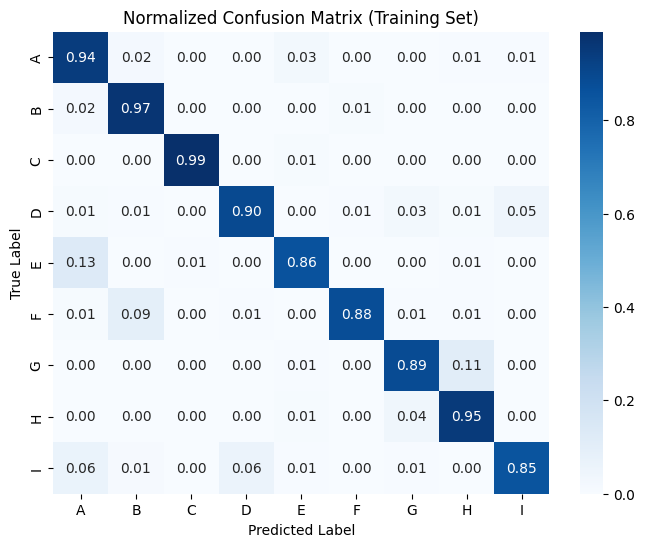

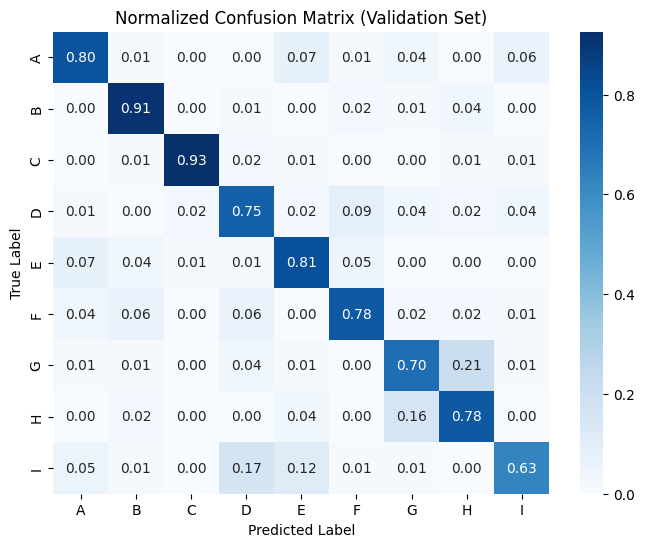

In [11]:

# Best hyperparameters found from tuning
best_params = best_hyperparams
print(f"Best Hyperparameters: {best_params}")
print(f"Best Model Path: {best_model_path}")

model = TransferGestureCNN(
    best_params["conv1_channels"],
    best_params["conv2_channels"],
    best_params["fc1_units"],
    best_params["fc2_units"],
    best_params["kernel_size"]
).to(device)

model.load_state_dict(torch.load(best_model_path))
model.eval()
with torch.no_grad():
    train_outputs = model(train_features)
    val_outputs = model(val_features)

train_accuracy = compute_accuracy(train_outputs, train_labels)
val_accuracy = compute_accuracy(val_outputs, val_labels)

print(f"\nFinal Train Accuracy: {train_accuracy:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy:.2f}%")

# Generate Confusion Matrix
train_preds = torch.argmax(train_outputs, dim=1).cpu().numpy()
train_labels_np = train_labels.cpu().numpy()
val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()
val_labels_np = val_labels.cpu().numpy()

# Compute confusion matrices
train_conf_matrix = confusion_matrix(train_labels_np, train_preds, normalize="true")
val_conf_matrix = confusion_matrix(val_labels_np, val_preds, normalize="true")

# Plot normalized confusion matrices
plot_confusion_matrix(train_conf_matrix, title="Normalized Confusion Matrix (Training Set)")
plot_confusion_matrix(val_conf_matrix, title="Normalized Confusion Matrix (Validation Set)")


Final Test Accuracy: 92.59%


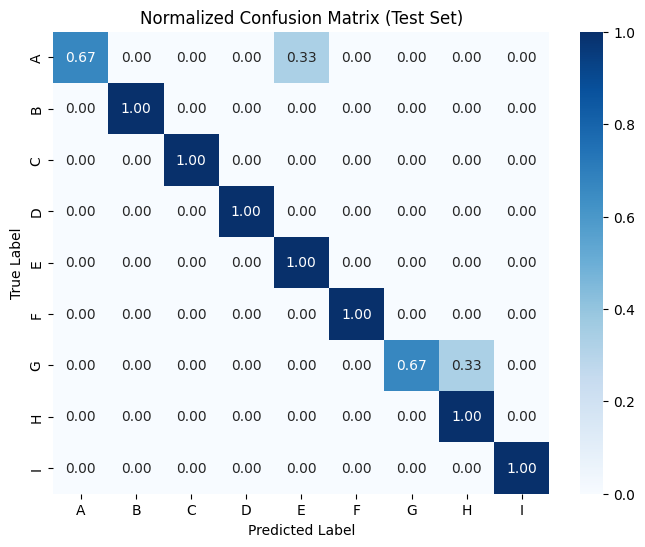

In [12]:
test_data = torch.load("saved_features/test_features.pth", weights_only=False)
test_features, test_labels = test_data["features"], test_data["labels"]
test_features, test_labels = test_features.to(device), test_labels.to(device)
with torch.no_grad():
    test_outputs = model(test_features)
    test_accuracy = compute_accuracy(test_outputs, test_labels)
print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")

test_preds = torch.argmax(test_outputs, dim=1).cpu().numpy()
test_labels_np = test_labels.cpu().numpy()
test_conf_matrix = confusion_matrix(test_labels_np, test_preds, normalize="true")
plot_confusion_matrix(test_conf_matrix, title="Normalized Confusion Matrix (Test Set)")

In [14]:
old_filename = best_model_path
new_filename = "best_transfer_gesture_cnn.pth"

if os.path.exists(old_filename):
    os.rename(old_filename, new_filename)
    print(f"✅ File renamed successfully: {old_filename} → {new_filename}")
else:
    print(f"⚠️ Error: {old_filename} does not exist. Renamed already.")


⚠️ Error: best_model_epoch26.pth does not exist. Renamed already.
